## Used packages

In [22]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
from ema_workbench.analysis import feature_scoring

import warnings
warnings.filterwarnings("ignore")

In [23]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,

)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

from ema_workbench import perform_experiments
from ema_workbench import Samplers
from ema_workbench import SequentialEvaluator

## Creating samples LHC

In [24]:
# ema_logging.log_to_stderr(ema_logging.INFO)

# Create an instance of the model which is usable with the EMA workbench
dike_model, planning_steps = get_model_for_problem_formulation(3)

to only focus on the scenarios no policies should be taken into account. Code below set all the 

In [25]:
zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})

pol0 = {}

for key in dike_model.levers:
    s1, s2 = key.name.split("_")
    pol0.update({key.name: zero_policy[s2]})

policy0 = Policy("Policy 0", **pol0)

In [26]:
with SequentialEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=40,policies=policy0,uncertainty_sampling=Samplers.LHS)

experiments, outcomes = results

100%|██████████████████████████████████████████| 40/40 [00:33<00:00,  1.18it/s]


In [27]:
experiments_unc =experiments.iloc[:,0:19]

In [28]:
outcomes.keys()

dict_keys(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])

In [35]:
df = pd.DataFrame(outcomes) 
df["Total Costs"] = df["A.1 Total Costs"] + df["A.2 Total Costs"] + df["A.3 Total Costs"] + df["A.4 Total Costs"] + df["A.5 Total Costs"]

In [38]:
df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df["A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]

In [39]:
outcomes_feaimp = outcomes

In [42]:
df_feature_importance_out = df[["Total Costs", "Expected Number of Deaths","A.5_Expected Number of Deaths", "A.5 Total Costs"]]

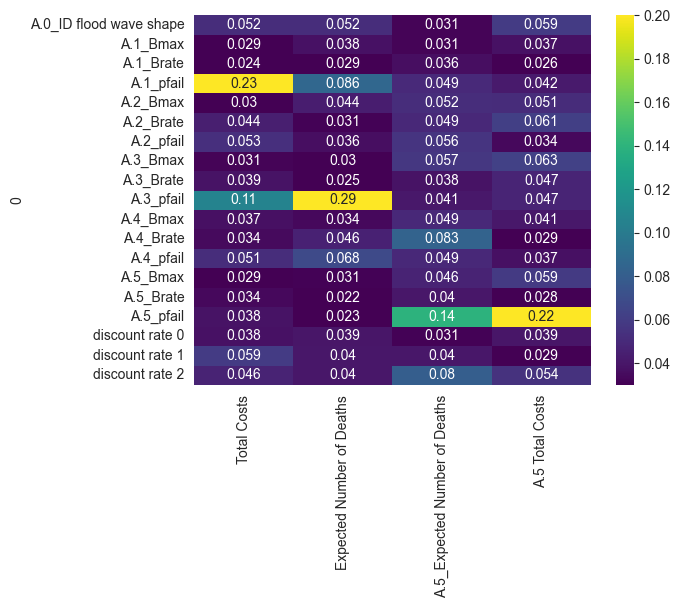

In [52]:
x = experiments_unc
y = df_feature_importance_out

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True,vmin = 0.03,vmax=0.2)
plt.show()

In [61]:
for x  in dike_model.uncertainties:
    print(x)

discount rate 0
discount rate 1
discount rate 2
A.0_ID flood wave shape
A.1_Bmax
A.1_pfail
A.1_Brate
A.2_Bmax
A.2_pfail
A.2_Brate
A.3_Bmax
A.3_pfail
A.3_Brate
A.4_Bmax
A.4_pfail
A.4_Brate
A.5_Bmax
A.5_pfail
A.5_Brate


In [56]:
new_uncertainties = []
for x  in dike_model.uncertainties:
    print(x)
    if x not in  ["A.0_ID flood wave shape","A.1_Bmax","A.1_Brate"]:
        

discount rate 0
discount rate 1
discount rate 2
A.0_ID flood wave shape
A.1_Bmax
A.1_pfail
A.1_Brate
A.2_Bmax
A.2_pfail
A.2_Brate
A.3_Bmax
A.3_pfail
A.3_Brate
A.4_Bmax
A.4_pfail
A.4_Brate
A.5_Bmax
A.5_pfail
A.5_Brate


In [60]:
"Bella" not in ["Bella", "Stella"]

False

In [ ]:
import pandas as pd

In [ ]:
df =pd.DataFrame(outcomes)

In [ ]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

In [ ]:
problem = get_SALib_problem(dike_model.uncertainties)
print(problem)

In [ ]:
Si = sobol.analyze(problem, outcomes["A.5 Total Costs"], calc_second_order=True, print_to_console=True)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [ ]:
Si = sobol.analyze(problem, outcomes["A.5_Expected Number of Deaths"], calc_second_order=True, print_to_console=True)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()